In [1]:
%matplotlib inline

In [4]:
# Import required modules
import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter

import seaborn as sns
sns.set_style("white")

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

In [7]:
x = np.array([1,2,3,4,5,6,7,8,9,10])
P = 5

x_p = x.reshape((len(x)//P, P)).T
print (x_p)

[[ 1  6]
 [ 2  7]
 [ 3  8]
 [ 4  9]
 [ 5 10]]


In [99]:
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = x.shape[0] // M // P
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    #x_summed = np.zeros((P, M * W))
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
    #for t in range(0, M*W):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

In [111]:
a = np.arange(20)
print (a)
b=a.reshape((5,4))
print (b)
b[:,1:3]
b_summed = np.zeros((5,4))
for t in range(4):
    #print (t)
    b_summed[:,t] = b.sum(axis=1)
    print (b_summed[t])
print (b_summed)
print (b_summed.T)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]
[ 6.  0.  0.  0.]
[ 22.  22.   0.   0.]
[ 38.  38.  38.   0.]
[ 54.  54.  54.  54.]
[[  6.   6.   6.   6.]
 [ 22.  22.  22.  22.]
 [ 38.  38.  38.  38.]
 [ 54.  54.  54.  54.]
 [ 70.  70.  70.  70.]]
[[  6.  22.  38.  54.  70.]
 [  6.  22.  38.  54.  70.]
 [  6.  22.  38.  54.  70.]
 [  6.  22.  38.  54.  70.]]


In [101]:
def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    #sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="hamming")
    win_coeffs *= sinc
    return win_coeffs

(0, 256)

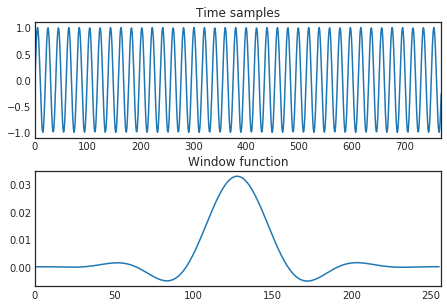

In [130]:
import matplotlib.pyplot as plt
M = 8
P = 32

x = np.sin(np.arange(0, M*P*10) / np.pi)
win_coeffs = generate_win_coeffs(M, P, window_fn="hann")
#win_coeffs = generate_win_coeffs(M, P, window_fn="hamming")
plt.subplot(2,1,1)
plt.title("Time samples")
plt.plot(x)
plt.xlim(0, M*P*3)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

plt.subplot(2,1,2)
plt.title("Window function")
plt.plot(win_coeffs)
plt.xlim(0, M*P)

In [131]:
y_p = pfb_fir_frontend(x, win_coeffs, M, P)

print ("n_taps: %i" % M)   
print ("n_branches: %i" % P)
print ("Input signal shape: %i" % x.shape)
print ("Window shape:       %i" % win_coeffs.shape)
print ("Output data shape: %s" % str(y_p.shape))

n_taps: 8
n_branches: 32
Input signal shape: 2560
Window shape:       256
Output data shape: (72, 32)


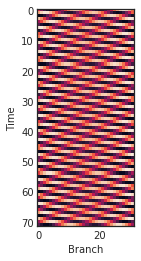

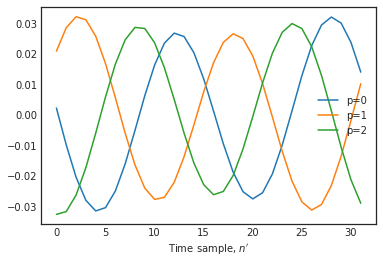

In [132]:
plt.figure()
plt.imshow(y_p)
#print (y_p)
plt.xlabel("Branch")
plt.ylabel("Time")

plt.figure()
plt.plot(y_p[0], label="p=0")
plt.plot(y_p[1], label="p=1")
plt.plot(y_p[2], label="p=2")
plt.xlabel("Time sample, $n'$")
plt.legend()

In [121]:
def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis)

def pfb_filterbank(x, win_coeffs, M, P):
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)

In [122]:
def pfb_spectrometer(x, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = np.abs(x_pfb)**2
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd

In [149]:
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 1000       # Number of windows of length M*P in input time stream
n_int = 2          # Number of time integrations on output data

# Generate a test data steam
samples = np.arange(M*P*W)
noise   = np.random.random(M*P*W) 
freq1 = 1
freq2 = 0.2
#amp  = 0.02
amp  = 0.05
cw_signal1 = amp * np.sin(1+samples * freq2)
cw_signal2 = amp * np.sin(samples * freq2)
data = noise + cw_signal

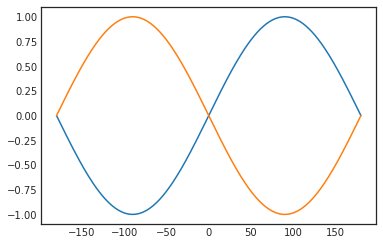

In [160]:
x = np.linspace(-np.pi, np.pi, 201)
y = np.linspace(-np.pi+np.pi/2, np.pi+np.pi/2, 201)
#print (x)
plt.plot(x*180/np.pi, np.sin(x))
plt.plot(x*180/np.pi, np.sin(x+np.pi))

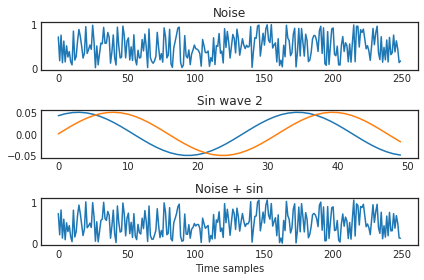

In [151]:
plt.subplot(3,1,1)
plt.title("Noise")
plt.plot(noise[:250])
plt.subplot(3,1,2)
plt.title("Sin wave 1")
plt.plot(cw_signal1[:50])
plt.title("Sin wave 2")
plt.plot(cw_signal2[:50])
plt.subplot(3,1,3)
plt.title("Noise + sin")
plt.plot(data[:250])
plt.xlabel("Time samples")
plt.tight_layout()

Text(0,0.5,'Time')

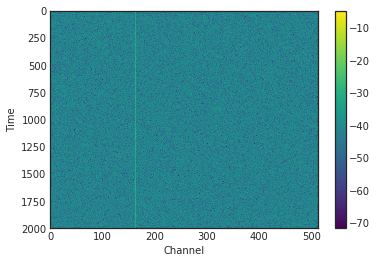

In [125]:
X_psd = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=2, window_fn="hamming")

plt.imshow(db(X_psd), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("Time")

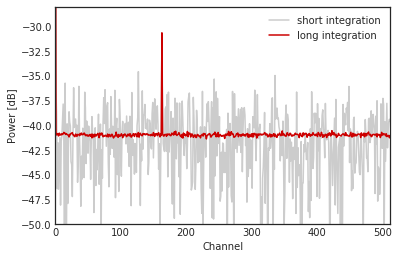

In [126]:
X_psd2 = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=1000, window_fn="hamming")

plt.plot(db(X_psd[0]), c='#cccccc', label='short integration')
plt.plot(db(X_psd2[1]), c='#cc0000', label='long integration')
plt.ylim(-50, -28)
plt.xlim(0, P/2)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.legend()

/home/peix/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,0,'Input sine wave period')

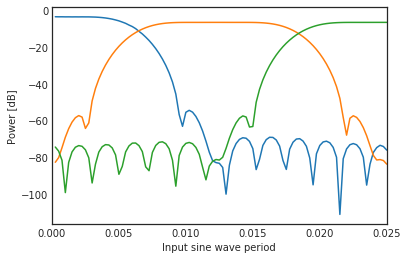

In [128]:
M, P, W = 6, 512, 256                   # taps, channels, windows
period = np.linspace(0, 0.025, 101)

chan0_val = []
chan1_val = []
chan2_val = []
for p in period:
    t = np.arange(0, M*P*W)
    x = np.sin(t * p)
    X_psd = pfb_spectrometer(x, n_taps=M, n_chan=P, n_int=256, window_fn="hamming")
    chan0_val.append(X_psd[0, 0])
    chan1_val.append(X_psd[0, 1])
    chan2_val.append(X_psd[0, 2])
    
    
plt.plot(period, db(chan0_val))
plt.plot(period, db(chan1_val))
plt.plot(period, db(chan2_val))
plt.xlim(period[0], period[-1])
plt.ylabel("Power [dB]")
plt.xlabel("Input sine wave period")